# BERT를 활용한 한국어 자연어 추론 모델

In [7]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 27.7 MB/s 
     |████████████████████████████████| 6.8 MB 48.7 MB/s 
     |████████████████████████████████| 895 kB 55.2 MB/s 
     |████████████████████████████████| 67 kB 4.7 MB/s 
     |████████████████████████████████| 596 kB 67.0 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [23]:
!pip install gluonnlp

     |████████████████████████████████| 344 kB 25.0 MB/s 
  Created wheel for gluonnlp: filename=gluonnlp-0.10.0-cp37-cp37m-linux_x86_64.whl size=595724 sha256=23c3c281d219e4d08d554f3cdf2f1b52cb2bcce3523e33950b37791f74e173ef
  Stored in directory: /root/.cache/pip/wheels/be/b4/06/7f3fdfaf707e6b5e98b79c041e023acffbe395d78a527eae00
Successfully built gluonnlp


In [25]:
!pip install mxnet

     |████████████████████████████████| 47.3 MB 1.6 MB/s 
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [35]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
from gluonnlp.data import SentencepieceTokenizer
import io

In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [39]:

DATA_IN_PATH = '/content/drive/MyDrive/Data/KorNLUDatasets/KorSTS'
1
TRAIN_STS_DF = os.path.join(DATA_IN_PATH,'sts-train.tsv')
train_data = pd.read_csv(TRAIN_STS_DF, sep='\t', quoting = 3)
train_data.head(10)


,genre,filename,year,id,score,sentence1,sentence2
0,main-captions,MSRvid,2012test,1,5.00,비행기가 이륙하고 있다.,비행기가 이륙하고 있다.
1,main-captions,MSRvid,2012test,4,3.80,한 남자가 큰 플루트를 연주하고 있다.,남자가 플루트를 연주하고 있다.
2,main-captions,MSRvid,2012test,5,3.80,한 남자가 피자에 치즈를 뿌려놓고 있다.,한 남자가 구운 피자에 치즈 조각을 뿌려놓고 있다.
3,main-captions,MSRvid,2012test,6,2.60,세 남자가 체스를 하고 있다.,두 남자가 체스를 하고 있다.
4,main-captions,MSRvid,2012test,9,4.25,한 남자가 첼로를 연주하고 있다.,자리에 앉은 남자가 첼로를 연주하고 있다.
5,main-captions,MSRvid,2012test,11,4.25,몇몇 남자들이 싸우고 있다.,두 남자가 싸우고 있다.
6,main-captions,MSRvid,2012test,12,0.50,남자가 담배를 피우고 있다.,남자가 스케이트를 타고 있다.
7,main-captions,MSRvid,2012test,13,1.60,남자가 피아노를 치고 있다.,남자가 기타를 연주하고 있다.
8,main-captions,MSRvid,2012test,14,2.20,한 남자가 기타를 치고 노래를 부르고 있다.,한 여성이 어쿠스틱 기타를 연주하고 노래를 부르고 있다.
9,main-captions,MSRvid,2012test,16,5.00,사람이 고양이를 천장에 던지고 있다.,사람이 고양이를 천장에 던진다.


In [40]:
print('전체 train data 개수 : {}'.format(len(train_data)))

전체 train data 개수 : 5749


In [42]:
train_set = pd.Series(train_data['sentence1'].tolist() + train_data['sentence2'].tolist()).astype(str)
train_set.head()


0             비행기가 이륙하고 있다.
1     한 남자가 큰 플루트를 연주하고 있다.
2    한 남자가 피자에 치즈를 뿌려놓고 있다.
3          세 남자가 체스를 하고 있다.
4        한 남자가 첼로를 연주하고 있다.
dtype: object

In [45]:
print('전체 문장 데이터의 개수 : {}'.format(len(train_set)))

전체 문장 데이터의 개수 : 11498


In [48]:
print('유일한 총 문장 수 : {}'.format(len(np.unique(train_set))))
print('반복해서 나타나는 문장의 수: {}'.format(np.sum(train_set.value_counts() > 1)))

유일한 총 문장 수 : 10383
반복해서 나타나는 문장의 수: 716


Text(0, 0.5, 'Number of sentence')

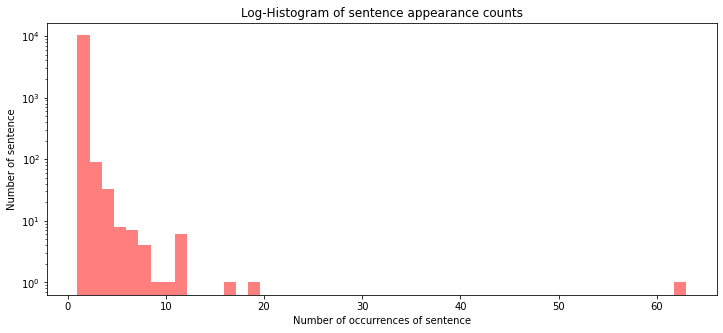

In [50]:
#  그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(12, 5))
# 히스토그램 선언
# bins: 히스토그램 값들에 대한 버켓 범위
# range: x축 값의 범위
# alpha: 그래프 색상 투명도
# color: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color= 'r', label='word')
plt.yscale('log', nonposy='clip')
# 그래프 제목
plt.title('Log-Histogram of sentence appearance counts')
# 그래프 x 축 라벨
plt.xlabel('Number of occurrences of sentence')
# 그래프 y 축 라벨
plt.ylabel('Number of sentence')

In [51]:
print('중복 최대 개수: {}'.format(np.max(train_set.value_counts())))
print('중복 최소 개수: {}'.format(np.min(train_set.value_counts())))
print('중복 평균 개수: {:.2f}'.format(np.mean(train_set.value_counts())))
print('중복 표준편차: {:.2f}'.format(np.std(train_set.value_counts())))
print('중복 중간길이: {}'.format(np.median(train_set.value_counts())))
# 사분위의 대한 경우는 0~100 스케일로 되어있음
print('제 1 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 25)))
print('제 3 사분위 중복: {}'.format(np.percentile(train_set.value_counts(), 75)))

중복 최대 개수: 63
중복 최소 개수: 1
중복 평균 개수: 1.11
중복 표준편차: 0.81
중복 중간길이: 1.0
제 1 사분위 중복: 1.0
제 3 사분위 중복: 1.0


{'boxes': [<matplotlib.lines.Line2D at 0x7faf6b8a7950>],
 'caps': [<matplotlib.lines.Line2D at 0x7faf6b881990>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faf6b37ded0>],
 'means': [<matplotlib.lines.Line2D at 0x7faf6b37d9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faf6b37d490>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7faf6b8a7ed0>,
  <matplotlib.lines.Line2D at 0x7faf6b881450>]}

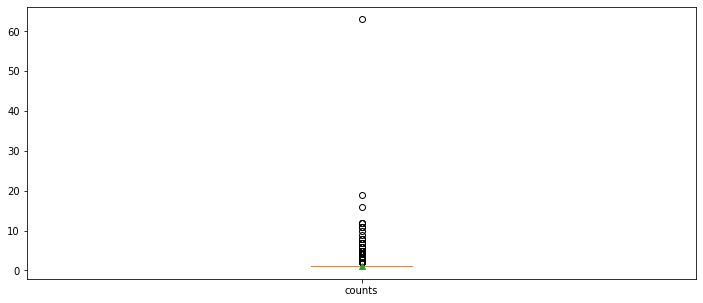

In [52]:
plt.figure(figsize=(12, 5))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를 입력
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 마크함

plt.boxplot([train_set.value_counts()],
             labels=['counts'],
             showmeans=True)

In [53]:
train_length = train_set.apply(len)

Text(0, 0.5, 'Probability')

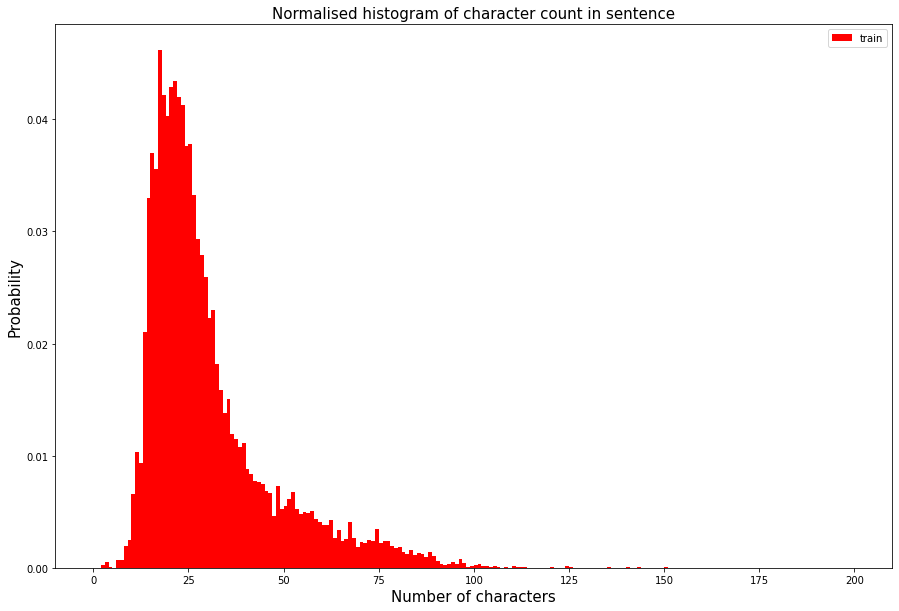

In [54]:
plt.figure(figsize=(15, 10))
plt.hist(train_length, bins=200, range=[0,200], facecolor='r', density=True, label='train')
plt.title("Normalised histogram of character count in sentence", fontsize=15)
plt.legend()
plt.xlabel('Number of characters', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [55]:
print('문장 길이 최대 값: {}'.format(np.max(train_length)))
print('문장 길이 평균 값: {:.2f}'.format(np.mean(train_length)))
print('문장 길이 표준편차: {:.2f}'.format(np.std(train_length)))
print('문장 길이 중간 값: {}'.format(np.median(train_length)))
print('문장 길이 제 1 사분위: {}'.format(np.percentile(train_length, 25)))
print('문장 길이 제 3 사분위: {}'.format(np.percentile(train_length, 75)))

문장 길이 최대 값: 150
문장 길이 평균 값: 29.80
문장 길이 표준편차: 16.76
문장 길이 중간 값: 25.0
문장 길이 제 1 사분위: 19.0
문장 길이 제 3 사분위: 35.0


{'boxes': [<matplotlib.lines.Line2D at 0x7faf6b034510>],
 'caps': [<matplotlib.lines.Line2D at 0x7faf6b031510>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faf6b03da90>],
 'means': [<matplotlib.lines.Line2D at 0x7faf6b03d550>],
 'medians': [<matplotlib.lines.Line2D at 0x7faf6b031fd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7faf6b034a50>,
  <matplotlib.lines.Line2D at 0x7faf6b034f90>]}

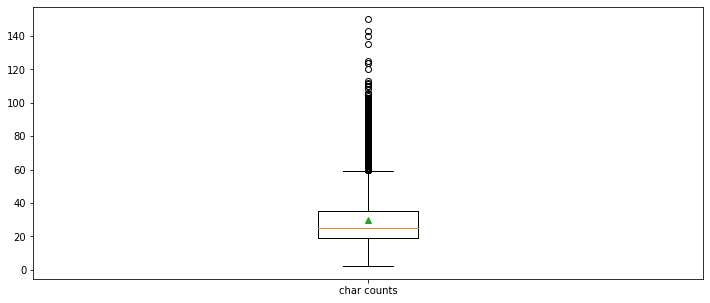

In [56]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_length,
             labels=['char counts'],
             showmeans=True)

In [57]:
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))

In [58]:
train_word_counts

0         3
1         6
2         6
3         5
4         5
         ..
11493     5
11494    12
11495     9
11496     8
11497    10
Length: 11498, dtype: int64

Text(0, 0.5, 'Prabability')

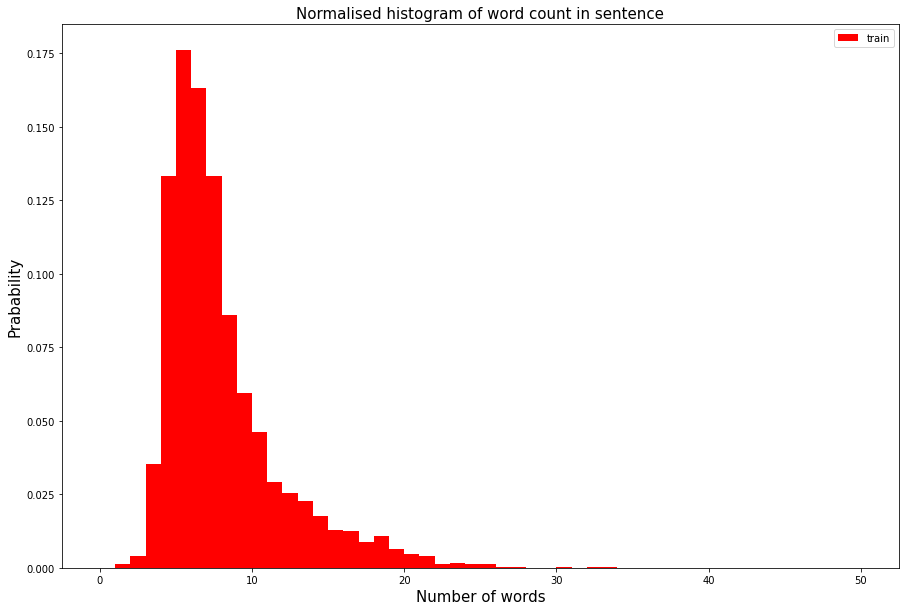

In [59]:
plt.figure(figsize=(15, 10))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of word count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of words', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [60]:
print('문장 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('문장 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('문장 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('문장 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('문장 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('문장 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('문장 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

문장 단어 개수 최대 값: 33
문장 단어 개수 평균 값: 7.50
문장 단어 개수 표준편차: 3.84
문장 단어 개수 중간 값: 6.0
문장 단어 개수 제 1 사분위: 5.0
문장 단어 개수 제 3 사분위: 9.0
문장 단어 개수 99 퍼센트: 21.0


{'boxes': [<matplotlib.lines.Line2D at 0x7faf6af29750>],
 'caps': [<matplotlib.lines.Line2D at 0x7faf6aeaf750>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faf6aeb7c90>],
 'means': [<matplotlib.lines.Line2D at 0x7faf6aeb7790>],
 'medians': [<matplotlib.lines.Line2D at 0x7faf6aeb7250>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7faf6af29c90>,
  <matplotlib.lines.Line2D at 0x7faf6aeaf210>]}

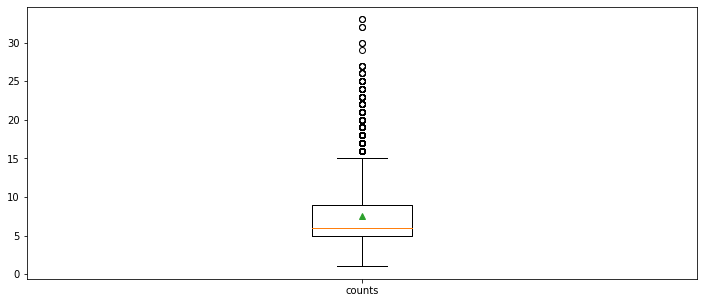

In [61]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_word_counts,
             labels=['counts'],
             showmeans=True)

In [62]:
qmarks = np.mean(train_set.apply(lambda x: '?' in x)) # 물음표가 구두점으로 쓰임
math = np.mean(train_set.apply(lambda x: '[math]' in x)) # []
fullstop = np.mean(train_set.apply(lambda x: '.' in x)) # 마침표
capital_first = np.mean(train_set.apply(lambda x: x[0].isupper())) #  첫번째 대문자
capitals = np.mean(train_set.apply(lambda x: max([y.isupper() for y in x]))) # 대문자가 몇개
numbers = np.mean(train_set.apply(lambda x: max([y.isdigit() for y in x]))) # 숫자가 몇개

In [63]:
print('물음표가있는 문장: {:.2f}%'.format(qmarks * 100))
print('마침표를 포함한 문장: {:.2f}%'.format(fullstop * 100))
print('첫 글자가 대문자 인 문장: {:.2f}%'.format(capital_first * 100))
print('대문자가있는 문장: {:.2f}%'.format(capitals * 100))
print('숫자가있는 문장: {:.2f}%'.format(numbers * 100))

물음표가있는 문장: 1.81%
마침표를 포함한 문장: 70.13%
첫 글자가 대문자 인 문장: 1.84%
대문자가있는 문장: 5.84%
숫자가있는 문장: 19.33%


In [66]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased', do_lower_case=True)

In [68]:
train_bert_token_counts = train_set.apply(lambda x : len(tokenizer.tokenize(x)))

Text(0, 0.5, 'Prabability')

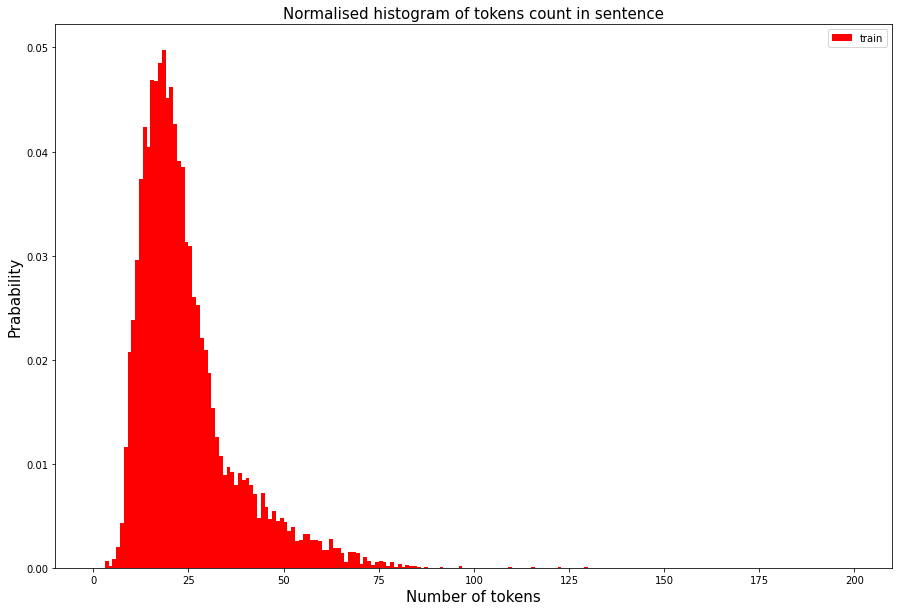

In [69]:
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_counts, bins=200, range=[0, 200], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [70]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_counts, 99)))

문장 tokens 개수 최대 값: 129
문장 tokens 개수 평균 값: 23.84
문장 tokens 개수 표준편차: 12.68
문장 tokens 개수 중간 값: 21.0
문장 tokens 개수 제 1 사분위: 15.0
문장 tokens 개수 제 3 사분위: 28.0
문장 tokens 개수 99 퍼센트: 67.0


{'boxes': [<matplotlib.lines.Line2D at 0x7faf6a2fa890>],
 'caps': [<matplotlib.lines.Line2D at 0x7faf6a2fd890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faf6a302dd0>],
 'means': [<matplotlib.lines.Line2D at 0x7faf6a3028d0>],
 'medians': [<matplotlib.lines.Line2D at 0x7faf6a302390>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7faf6a2fadd0>,
  <matplotlib.lines.Line2D at 0x7faf6a2fd350>]}

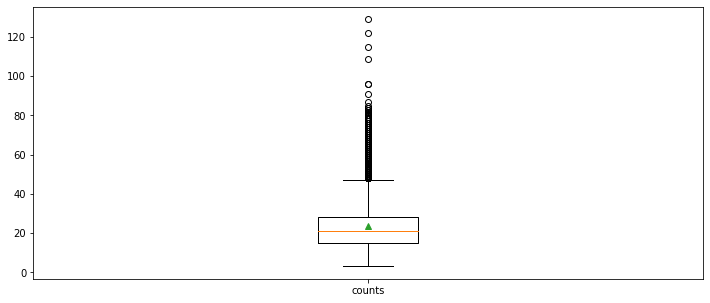

In [71]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_counts,
             labels=['counts'],
             showmeans=True)

In [72]:
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased', do_lower_case=False)

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/972k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.87M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [73]:
train_bert_token_cased_counts = train_set.apply(lambda x:len(tokenizer.tokenize(x)))

Text(0, 0.5, 'Prabability')

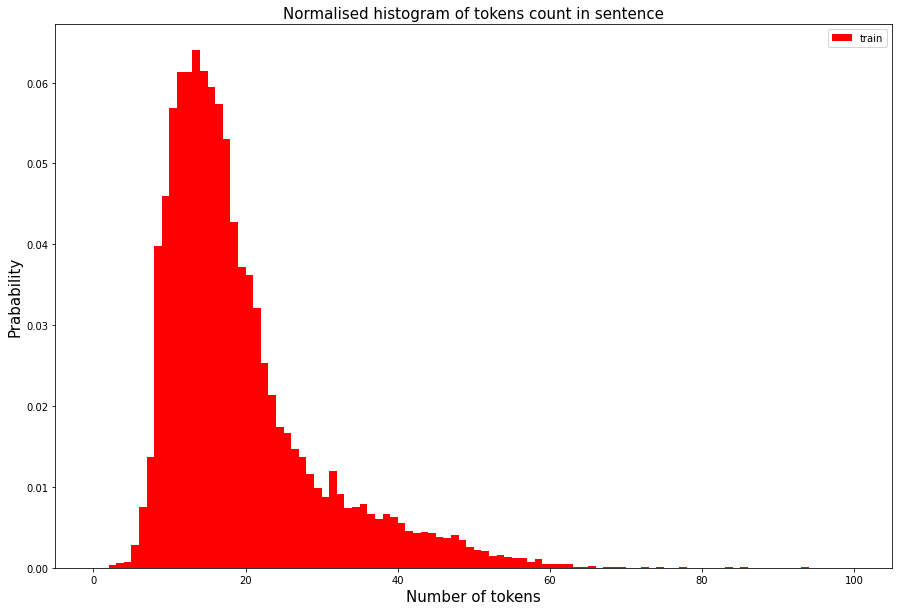

In [74]:
plt.figure(figsize=(15, 10))
plt.hist(train_bert_token_cased_counts, bins=100, range=[0, 100], facecolor='r', density=True, label='train')
plt.title('Normalised histogram of tokens count in sentence', fontsize=15)
plt.legend()
plt.xlabel('Number of tokens', fontsize=15)
plt.ylabel('Prabability', fontsize=15)

In [75]:
print('문장 tokens 개수 최대 값: {}'.format(np.max(train_bert_token_cased_counts)))
print('문장 tokens 개수 평균 값: {:.2f}'.format(np.mean(train_bert_token_cased_counts)))
print('문장 tokens 개수 표준편차: {:.2f}'.format(np.std(train_bert_token_cased_counts)))
print('문장 tokens 개수 중간 값: {}'.format(np.median(train_bert_token_cased_counts)))
print('문장 tokens 개수 제 1 사분위: {}'.format(np.percentile(train_bert_token_cased_counts, 25)))
print('문장 tokens 개수 제 3 사분위: {}'.format(np.percentile(train_bert_token_cased_counts, 75)))
print('문장 tokens 개수 99 퍼센트: {}'.format(np.percentile(train_bert_token_cased_counts, 99)))

문장 tokens 개수 최대 값: 102
문장 tokens 개수 평균 값: 18.74
문장 tokens 개수 표준편차: 10.12
문장 tokens 개수 중간 값: 16.0
문장 tokens 개수 제 1 사분위: 12.0
문장 tokens 개수 제 3 사분위: 22.0
문장 tokens 개수 99 퍼센트: 53.0


{'boxes': [<matplotlib.lines.Line2D at 0x7faf6a1d8310>],
 'caps': [<matplotlib.lines.Line2D at 0x7faf6a1e0310>,
 'fliers': [<matplotlib.lines.Line2D at 0x7faf6a166850>],
 'means': [<matplotlib.lines.Line2D at 0x7faf6a166350>],
 'medians': [<matplotlib.lines.Line2D at 0x7faf6a1e0dd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7faf6a1d8850>,
  <matplotlib.lines.Line2D at 0x7faf6a1d8d90>]}

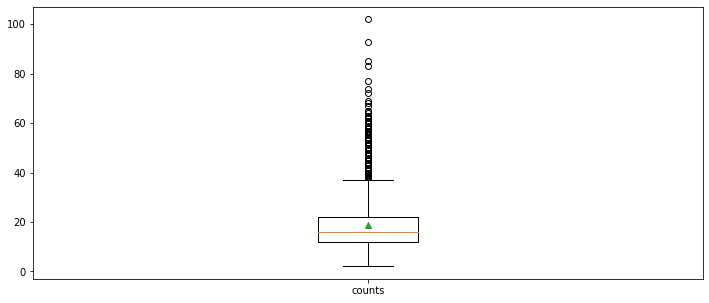

In [76]:
plt.figure(figsize=(12, 5))

plt.boxplot(train_bert_token_cased_counts,
             labels=['counts'],
             showmeans=True)